
# Partial Least Squares Discriminant Analysis (PLS‑DA) for Beta-Cell Diabetes Prediction (VIP per Mehmood *et al.*, 2015)

This notebook implements a Partial Least Squares Discriminant Analysis (PLS‑DA) on mouse beta-cell scRNA-seq data to classify cells as diabetic or non-diabetic, reports standard evaluation metrics (accuracy, precision/PPV, recall/sensitivity, F1-score, AUC-ROC), and computes a Variable Importance in Projection (VIP) for variable selection.

**VIP (Variable Importance in Projection)** (Mahieu *et al.*, 2023):

For a PLS1 model with \(m\) components, the VIP index for the \(j^\text{th}\) variable is:
$$
\mathrm{VIP}_j \;=\; \sqrt{\,\frac{p \,\displaystyle\sum_{h=1}^{m} R^2\!\big(y,t_h\big)\, w_{hj}^{2}}
{\displaystyle\sum_{h=1}^{m} R^2\!\big(y,t_h\big)}\, } \, .
$$
where \(p\) is the number of genes (variables), \(m\) is the number of retained components, \(R^2(y,t_h)\) is the proportion of response variance explained by component \(h\), and \(w_{hj}\) is the loading-weight of gene \(j\) on component \(h\).

*Reference*: Mahieu, B., Qannari, E. M., & Jaillais, B. (2023). *Extension and significance testing of Variable Importance in Projection (VIP) indices in Partial Least Squares regression and Principal Components Analysis.*. **Chemometrics and Intelligent Laboratory Systems**, 242, 104986.


In [ ]:
# Imports
import os
import numpy as np
import pandas as pd

try:
    import anndata as ad
except Exception as e:
    ad = None
    print("anndata not available. Install with: pip install anndata scanpy")

from scipy import sparse
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.cross_decomposition import PLSRegression

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:

# --- User configuration ---
H5AD_PATH = '/Users/mdelaluz/Documents/MSC KIDS UCL/Dissertation/Methodology/mouse_atlas_filtered_ML.h5ad'
LABEL_COL = "healthy_vs_T2D"

# Model/metrics config
N_COMPONENTS_GRID = [1, 2, 3]
TEST_SIZE = 0.2
RANDOM_STATE = 42
KFOLDS = 5

In [3]:
# --- Load AnnData ---
if ad is None:
    raise ImportError("anndata is required to read .h5ad files. Install with: pip install anndata scanpy")

adata = ad.read_h5ad(H5AD_PATH)
print(adata)

# --- Expression matrix -------------------------------------------------------
is_sparse = sparse.issparse(adata.X)
X = adata.X.toarray() if is_sparse else np.asarray(adata.X)
X = X.astype(np.float32, copy=False)
genes = adata.var_names.to_list() if hasattr(adata, "var_names") else [f"g{i}" for i in range(X.shape[1])]
print("Expression matrix:", X.shape, "(sparse→dense)" if is_sparse else "(dense)")

# --- Labels: healthy=0 , T2D=1 ----------------------------------------------
if LABEL_COL not in adata.obs.columns:
    raise KeyError(f"'{LABEL_COL}' not found in adata.obs. Available: {list(adata.obs.columns)}")

labels = adata.obs[LABEL_COL].astype(str).str.strip()
# Exact mapping (case-sensitive), as requested:
mask = labels.isin(["healthy", "T2D"])
# If you need a robust, case-insensitive fallback, uncomment the next two lines:
# labels_ci = labels.str.lower()
# mask = labels_ci.isin(["healthy","t2d"])

X = X[mask.values]
y = labels.loc[mask].map({"healthy": 0, "T2D": 1}).to_numpy(dtype=int)

print("Kept rows:", int(mask.sum()), "— label counts (0=healthy,1=T2D):", np.bincount(y, minlength=2))


AnnData object with n_obs × n_vars = 67613 × 1998
    obs: 'batch_integration', 'dataset', 'design', 'cell_cycle_phase', 'ins_high', 'gcg_high', 'sst_high', 'ppy_high', 'cell_filtering', 'strain', 'age', 'cell_type_originalDataset_unified', 'cell_type_originalDataset', 'cell_type_reannotatedIntegrated', 'n_genes', 'mt_frac', 'doublet_score', 'log10_n_counts', 'age_approxDays', 'dataset__design__sample', 'cell_subtype_immune_reannotatedIntegrated', 'cell_subtype_endothelial_reannotatedIntegrated', 'emptyDrops_LogProb_scaled', 'cell_subtype_beta_coarse_reannotatedIntegrated', 'cell_subtype_beta_fine_reannotatedIntegrated', 'GP_1', 'GP_2', 'GP_3', 'GP_4', 'GP_5', 'GP_6', 'GP_7', 'GP_8', 'GP_9', 'GP_10', 'GP_11', 'GP_12', 'GP_13', 'GP_14', 'GP_15', 'GP_16', 'GP_17', 'GP_18', 'GP_19', 'GP_20', 'GP_21', 'GP_22', 'GP_23', 'GP_24', 'GP_25', 'GP_26', 'GP_27', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'diabetes_model', 'chemical_stress', 'GEO_a

In [4]:

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape


((54090, 1998), (13523, 1998))

In [5]:
# Cross-validation for component selection
def cv_auc_for_components(X_tr, y_tr, components_grid, kfolds=5, seed=42):
    results = {}
    skf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=seed)
    for A in components_grid:
        aucs = []
        for tr_idx, val_idx in skf.split(X_tr, y_tr):
            X_tr_fold, X_val_fold = X_tr[tr_idx], X_tr[val_idx]
            y_tr_fold, y_val_fold = y_tr[tr_idx], y_tr[val_idx]

            scaler = StandardScaler(with_mean=True, with_std=True)
            X_trs = scaler.fit_transform(X_tr_fold)
            X_vals = scaler.transform(X_val_fold)

            pls = PLSRegression(n_components=A)
            pls.fit(X_trs, y_tr_fold)

            # Scores
            T_tr = pls.transform(X_trs)
            T_val = pls.transform(X_vals)

            # Logistic classifier on scores
            clf = LogisticRegression(max_iter=500, class_weight="balanced")
            clf.fit(T_tr, y_tr_fold)

            y_prob = clf.predict_proba(T_val)[:, 1]  # probability for class 1 (T2D)
            auc = roc_auc_score(y_val_fold, y_prob)
            aucs.append(auc)
        results[A] = float(np.mean(aucs))
    return results

cv_results = cv_auc_for_components(X_train, y_train, N_COMPONENTS_GRID, kfolds=KFOLDS, seed=RANDOM_STATE)
cv_results


{1: 0.9979897691601416, 2: 0.9983470431986119, 3: 0.9990765313501117}

In [6]:
#Select best A and refit

best_A = max(cv_results, key=cv_results.get)
print("CV AUC by A:", cv_results, "| Selected A:", best_A)

scaler_final = StandardScaler(with_mean=True, with_std=True)
X_trs = scaler_final.fit_transform(X_train)
X_tes = scaler_final.transform(X_test)

pls_final = PLSRegression(n_components=best_A)
pls_final.fit(X_trs, y_train)

T_train = pls_final.transform(X_trs)
T_test  = pls_final.transform(X_tes)

clf_final = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
clf_final.fit(T_train, y_train)


CV AUC by A: {1: 0.9979897691601416, 2: 0.9983470431986119, 3: 0.9990765313501117} | Selected A: 3


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [7]:
# Evaluation on held-out test set

y_prob = clf_final.predict_proba(T_test)[:, 1]  # prob of class 1 (T2D)
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC-ROC: {auc:.3f}\n")
print("Classification report:\n", classification_report(y_test, y_pred, target_names=["healthy (0)", "T2D (1)"]))

Accuracy: 0.989
Precision: 0.988
Recall: 0.985
F1-score: 0.986
AUC-ROC: 0.999

Classification report:
               precision    recall  f1-score   support

 healthy (0)       0.99      0.99      0.99      7903
     T2D (1)       0.99      0.99      0.99      5620

    accuracy                           0.99     13523
   macro avg       0.99      0.99      0.99     13523
weighted avg       0.99      0.99      0.99     13523



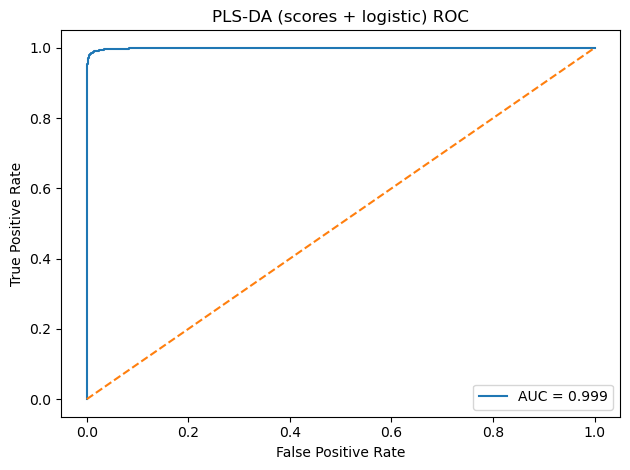

             pred healthy  pred T2D
healthy (0)          7834        69
T2D (1)                83      5537


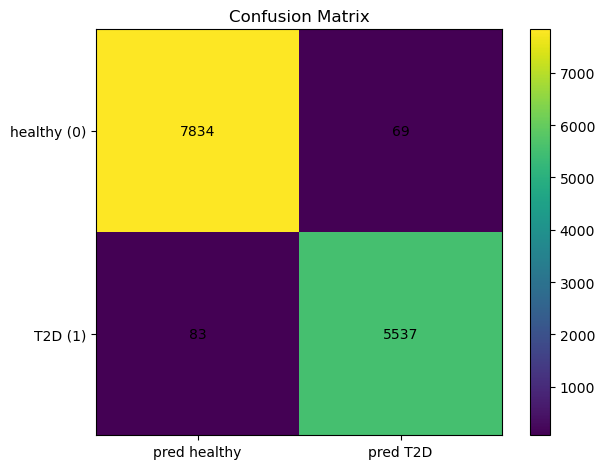

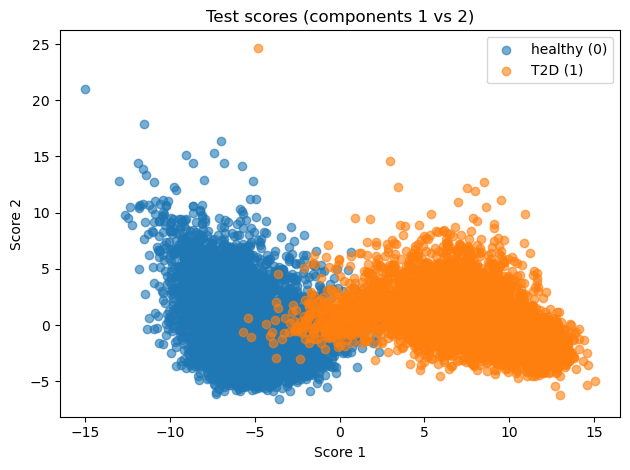

In [10]:

# ROC
fpr, tpr, thr = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("PLS-DA (scores + logistic) ROC")
plt.legend()
plt.tight_layout()
plt.show()

# # Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=["healthy (0)", "T2D (1)"],
                     columns=["pred healthy", "pred T2D"])
print(cm_df)

# Plot confusion matrix with annotations
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")  # default colormap (viridis)

# Axis ticks and labels
ax.set_xticks([0, 1], labels=["pred healthy", "pred T2D"])
ax.set_yticks([0, 1], labels=["healthy (0)", "T2D (1)"])
ax.set_title("Confusion Matrix")

# Colorbar
fig.colorbar(im, ax=ax)

# Add the count text in each cell
# Use a dynamic text color for readability (set to "black" if you prefer fixed color like your screenshot)
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):          # rows
    for j in range(cm.shape[1]):      # cols
        ax.text(j, i, f"{cm[i, j]:d}",
                ha="center", va="center",
                color="black", fontsize=10)

fig.tight_layout()
plt.show()

# Score plots
if best_A >= 2:
    plt.figure()
    plt.scatter(T_test[y_test==0, 0], T_test[y_test==0, 1], alpha=0.6, label="healthy (0)")
    plt.scatter(T_test[y_test==1, 0], T_test[y_test==1, 1], alpha=0.6, label="T2D (1)")
    plt.xlabel("Score 1")
    plt.ylabel("Score 2")
    plt.title("Test scores (components 1 vs 2)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    plt.figure()
    plt.hist(T_test[y_test==0, 0], bins=30, alpha=0.6, label="healthy (0)")
    plt.hist(T_test[y_test==1, 0], bins=30, alpha=0.6, label="T2D (1)")
    plt.xlabel("Score 1")
    plt.ylabel("Count")
    plt.title("Test scores (component 1)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# VIP per Mahieu et al. (2023) — PLS1, Section 2.1
def compute_vip_mahieu_pls1(pls, X, y):
    """
    Compute VIP scores following Mahieu et al. (2023), Eq. in Sec. 2.1 (PLS1):
        VIP_j = sqrt( p * sum_h R^2(y, t_h) * w_{hj}^2 / sum_h R^2(y, t_h) )

    Parameters
    ----------
    pls : fitted sklearn PLSRegression (PLS-DA with single response)
    X   : array-like, shape (n_samples, n_features) used to fit `pls`
    y   : array-like, shape (n_samples,) or (n_samples, 1) response used to fit `pls`

    Returns
    -------
    vip : np.ndarray, shape (n_features,)
    """
    # Extract X-scores (T) and X-weights (W)
    T = pls.x_scores_            # (n, m)
    W = pls.x_weights_.copy()    # (p, m)

    # Ensure column-wise unit-norm weights as required in the paper (‖w_h‖ = 1)
    col_norms = np.linalg.norm(W, axis=0, keepdims=True)
    col_norms[col_norms == 0.0] = 1.0
    W /= col_norms

    # Center y (scikit-learn already centers internally, but we re-center for safety)
    y = np.asarray(y).reshape(-1, 1)
    y = y - y.mean(axis=0)

    # Precompute y'y (variance up to a constant factor)
    yy = float((y.T @ y)) if y.size else 0.0
    if yy == 0.0:
        # Degenerate case: constant y ⇒ all VIPs are zero
        return np.zeros(W.shape[0], dtype=float)

    # Compute R^2(y, t_h) per component (cov^2 / (var(y)*var(t_h)))
    m = T.shape[1]
    R2 = np.empty(m, dtype=float)
    for h in range(m):
        t = T[:, [h]]
        cov2 = float((y.T @ t) ** 2)          # (1x1) squared covariance (without 1/n factor)
        tt   = float(t.T @ t)                 # t'h t_h
        R2[h] = cov2 / (yy * tt) if tt > 0 else 0.0

    # Avoid division by zero
    R2_sum = R2.sum()
    if R2_sum == 0.0:
        return np.zeros(W.shape[0], dtype=float)

    # Apply VIP formula
    p = W.shape[0]                            # number of variables (genes)
    vip_sq = p * (W**2 @ R2) / R2_sum         # (p,)
    vip = np.sqrt(np.maximum(vip_sq, 0.0))
    return vip

vip_scores = compute_vip_mahieu_pls1(pls_final, X_train, y_train)
vip_df = (
    pd.DataFrame({"gene": genes, "VIP": vip_scores})
      .sort_values("VIP", ascending=False)
      .reset_index(drop=True)
)

In [12]:
import mygene
mg = mygene.MyGeneInfo()

FIELDS = ["name", "entrezgene", "go.BP.term", "go.MF.term", "pathway.kegg"]
query_ids = [g.split('.')[0] for g in vip_df["gene"]]   # strip version
hits = mg.querymany(query_ids, scopes="ensembl.gene",
                    fields=",".join(FIELDS), species="mouse",
                    as_dataframe=True)

ann = (hits.reset_index()
           .rename(columns={"query": "ensembl"})
           .drop_duplicates(subset="ensembl"))

for col in ["go.BP.term", "go.MF.term"]:
    if col in ann.columns:
        ann[col] = ann[col].apply(lambda x: x[0] if isinstance(x, list) and len(x)>0 else x)

if "pathway.kegg" in ann.columns:
    def _first_kegg(x):
        if isinstance(x, dict) and len(x)>0:
            return list(x.keys())[0]
        return pd.NA
    ann["kegg"] = ann["pathway.kegg"].apply(_first_kegg)

top_enriched = (vip_df
                .assign(ensembl = vip_df["gene"].str.split('.').str[0])
                .merge(ann[["ensembl", "name", "entrezgene", "go.BP.term", "go.MF.term", "kegg"]],
                       on="ensembl", how="left")
                .drop(columns=["ensembl"]))

display(top_enriched.head(21))


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found no hit:	['ENSMUSG00000038917']


,gene,VIP,name,entrezgene,go.BP.term,go.MF.term,kegg
0,ENSMUSG00000035540,5.143787,vitamin D binding protein,14473,NaN,NaN,<NA>
1,ENSMUSG00000026335,4.829253,peptidylglycine alpha-amidating monooxygenase,18484,NaN,NaN,<NA>
2,ENSMUSG00000032181,4.720401,secretogranin III,20255,NaN,protein binding,<NA>
3,ENSMUSG00000022490,4.658214,"protein phosphatase 1, regulatory inhibitor su...",58200,NaN,NaN,<NA>
4,ENSMUSG00000003355,4.633211,FK506 binding protein 11,66120,NaN,NaN,<NA>
5,ENSMUSG00000050711,4.618089,secretogranin II,20254,NaN,NaN,<NA>
6,ENSMUSG00000032532,4.525067,cholecystokinin,12424,NaN,NaN,<NA>
7,ENSMUSG00000009246,4.514839,"transient receptor potential cation channel, s...",56843,NaN,NaN,<NA>
8,ENSMUSG00000015401,4.506695,"collectrin, amino acid transport regulator",57394,NaN,NaN,<NA>
9,ENSMUSG00000018451,4.471279,RIKEN cDNA 6330403K07 gene,103712,NaN,NaN,<NA>
